In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics import AUROC
import torch.nn.functional as F

from func2graph.data import data_simulator, generate_simulation_data
from func2graph import models, tools, baselines

### Simulation Data

In [17]:
strength_matrix = np.zeros((4, 4))
strength_matrix[0, 0] = 0.3
strength_matrix[1, 0] = 0.59
strength_matrix[2, 0] = 0.88
strength_matrix[3, 0] = 1.89

strength_matrix[0, 1] = -0.43
strength_matrix[1, 1] = -0.53
strength_matrix[2, 1] = -0.60
strength_matrix[3, 1] = -0.44

strength_matrix[0, 2] = -0.31
strength_matrix[1, 2] = -0.43
strength_matrix[2, 2] = -0.43
strength_matrix[3, 2] = -0.79

strength_matrix[0, 3] = -0.25
strength_matrix[1, 3] = -0.30
strength_matrix[2, 3] = -0.42
strength_matrix[3, 3] = -0.33


cutoff_matrix = np.zeros((4, 4))
cutoff_matrix[0, 0] = 13/229
cutoff_matrix[1, 0] = 22/53
cutoff_matrix[2, 0] = 20/67
cutoff_matrix[3, 0] = 11/68

cutoff_matrix[0, 1] = 18/52
cutoff_matrix[1, 1] = 45/114
cutoff_matrix[2, 1] = 8/88
cutoff_matrix[3, 1] = 0/54

cutoff_matrix[0, 2] = 13/56
cutoff_matrix[1, 2] = 15/84
cutoff_matrix[2, 2] = 8/154
cutoff_matrix[3, 2] = 25/84

cutoff_matrix[0, 3] = 3/62
cutoff_matrix[1, 3] = 1/54
cutoff_matrix[2, 3] = 12/87
cutoff_matrix[3, 3] = 2/209

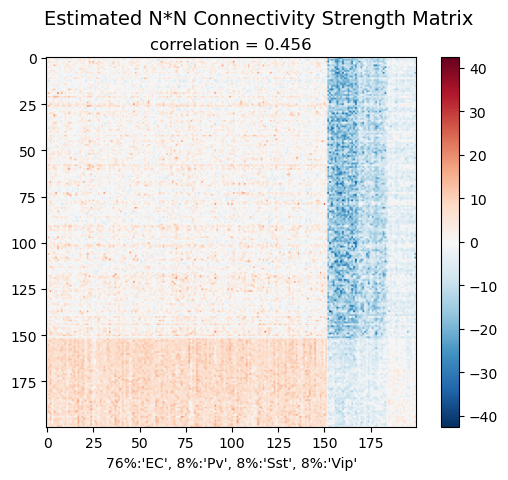

In [15]:
nn_strength_W = np.load('../output/11_13_sim_data/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_42_32_128_128_0_1_1_200_64_0_5e-05_lookup_table_spatial_temporal_1_none_cycle_0.0/Estimated_W_42.npy')

max_abs = np.max(np.abs(nn_strength_W))
plt.imshow(-1*nn_strength_W, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xlabel("76%:'EC', 8%:'Pv', 8%:'Sst', 8%:'Vip'")
plt.suptitle("Estimated N*N Connectivity Strength Matrix", fontsize=14)
plt.title("correlation = 0.456")
plt.show()

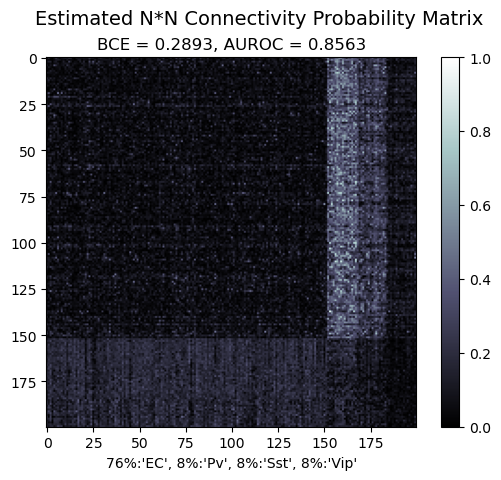

In [18]:
nn_prob_W = np.abs(nn_strength_W)
nn_prob_W = (nn_prob_W - np.min(nn_prob_W)) / (np.max(nn_prob_W) - np.min(nn_prob_W))

plt.imshow(nn_prob_W, cmap='bone')
plt.colorbar()
plt.xlabel("76%:'EC', 8%:'Pv', 8%:'Sst', 8%:'Vip'")
plt.suptitle("Estimated N*N Connectivity Probability Matrix", fontsize=14)
plt.title("BCE = 0.2893, AUROC = 0.8563")
plt.show()

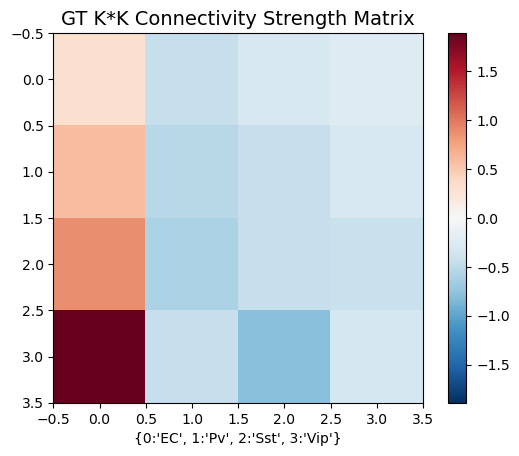

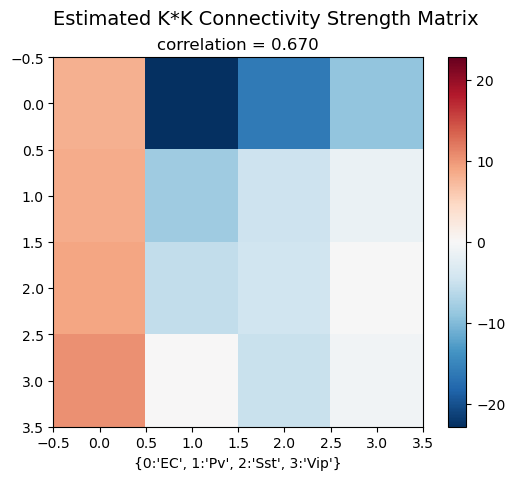

In [23]:
max_abs = np.max(np.abs(strength_matrix))
plt.imshow(strength_matrix, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.title("GT K*K Connectivity Strength Matrix", fontsize=14)
plt.xlabel("{0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}")
plt.show()

kk_strength_W = np.load('../output/11_13_sim_data/Attention_Autoencoder_wuwei_200_0.001_0.3_2_5_1.0_1.0_30000_42_cell_type_200_prediction_1_42_32_128_128_0_1_1_200_64_0_5e-05_lookup_table_spatial_temporal_1_none_cycle_0.0/cell_type_level_W_42.npy')

max_abs = np.max(np.abs(kk_strength_W))
plt.imshow(-1*kk_strength_W, cmap='RdBu_r', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.suptitle("Estimated K*K Connectivity Strength Matrix", fontsize=14)
plt.title("correlation = 0.670")
plt.xlabel("{0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}")
plt.show()

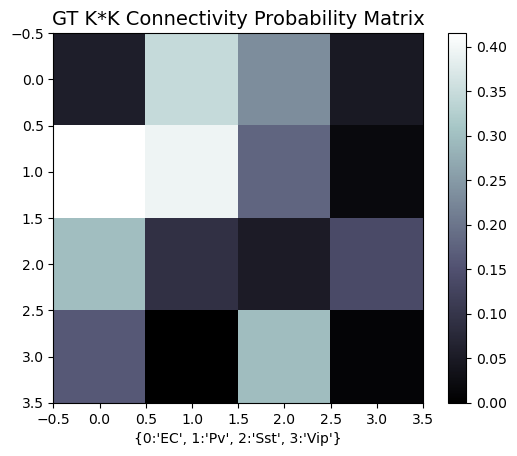

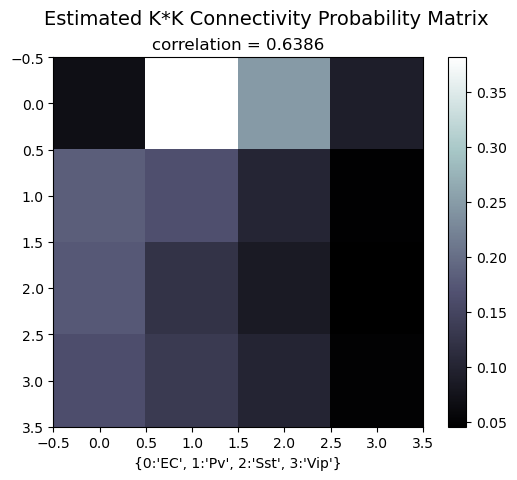

In [26]:
neuron_num = 200
cell_type_count = {'EC':int(neuron_num*0.76), 'Pv':int(neuron_num*0.08), 'Sst':int(neuron_num*0.08), 'Vip':int(neuron_num*0.08)}
cell_type_id2cell_type = {0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}

kk_prob_W = tools.calculate_cell_type_level_connectivity_matrix(
    connectivity_matrix_new=nn_prob_W,
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

corr = np.corrcoef(kk_prob_W.flatten(), cutoff_matrix.flatten())[0, 1]

plt.imshow(cutoff_matrix, cmap='bone')
plt.colorbar()
plt.title("GT K*K Connectivity Probability Matrix", fontsize=14)
plt.xlabel("{0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}")
plt.show()

plt.imshow(kk_prob_W, cmap='bone')
plt.colorbar()
plt.suptitle("Estimated K*K Connectivity Probability Matrix", fontsize=14)
plt.title("correlation = {:.4f}".format(corr))
plt.xlabel("{0:'EC', 1:'Pv', 2:'Sst', 3:'Vip'}")
plt.show()

### Real Mouse Data